In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import datetime

In [2]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport

In [3]:
# Load the data
file_path = Path('Resources/financials_and_sentiments.csv')
df = pd.read_csv(file_path)

In [4]:
df.head()

,Ticker,Date,Pos,Neu,Neg,Normalized,Close,Returns,12-day Rolling,5-day Rolling,3-day Rolling,12-day Rolling Std,5-day Rolling Std,3-day Rolling Std,difference 1-day,difference 3-days,direction 1-day,direction 3-days
0,A,2019-08-14,0.101,0.884,0.014,1,65.59,-0.030308,-0.005657,-0.006860,-0.014811,0.020223,0.024598,0.025959,-2.05,-3.05,0,0
1,AAL,2019-10-24,0.133,0.847,0.020,1,29.41,0.039590,0.009595,0.010526,0.009358,0.015567,0.019245,0.027056,1.12,0.79,1,1
2,AAP,2019-11-12,0.121,0.863,0.015,1,156.14,-0.075110,-0.004594,-0.014186,-0.025911,0.024032,0.035081,0.043719,-12.68,-13.14,0,0
3,AAPL,2019-10-30,0.130,0.851,0.018,1,243.26,-0.000123,0.002627,0.000145,-0.004411,0.010672,0.014049,0.016983,-0.03,-3.32,0,0
4,ABBV,2019-11-01,0.118,0.862,0.020,1,81.75,0.027656,0.007551,0.013349,0.013813,0.011847,0.012865,0.014565,2.20,3.28,1,1


In [5]:
#Create new field for month of earnings call"
df['month'] = pd.DatetimeIndex(df['Date']).month

In [9]:
#Dropping columns not needed for model and NAs
columns_to_drop = ["Ticker","Date","Normalized","Close","Returns",
                   "difference 1-day","difference 3-days","direction 1-day"]
df_post3days = df.drop(columns=columns_to_drop)
df_post3days.dropna(inplace=True)

In [10]:
df_post3days.head()

,Pos,Neu,Neg,12-day Rolling,5-day Rolling,3-day Rolling,12-day Rolling Std,5-day Rolling Std,3-day Rolling Std,direction 3-days,month
0,0.101,0.884,0.014,-0.005657,-0.006860,-0.014811,0.020223,0.024598,0.025959,0,8
1,0.133,0.847,0.020,0.009595,0.010526,0.009358,0.015567,0.019245,0.027056,1,10
2,0.121,0.863,0.015,-0.004594,-0.014186,-0.025911,0.024032,0.035081,0.043719,0,11
3,0.130,0.851,0.018,0.002627,0.000145,-0.004411,0.010672,0.014049,0.016983,0,10
4,0.118,0.862,0.020,0.007551,0.013349,0.013813,0.011847,0.012865,0.014565,1,11


# Split training and test

In [12]:
# Create our features
X = df_post3days.drop(columns="direction 3-days")

# Create our target
y = df_post3days["direction 3-days"]

In [13]:
X.describe()

,Pos,Neu,Neg,12-day Rolling,5-day Rolling,3-day Rolling,12-day Rolling Std,5-day Rolling Std,3-day Rolling Std,month
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,0.122707,0.858085,0.019189,0.002394,0.002964,0.003260,0.017249,0.019393,0.040492,10.082949
std,0.019524,0.019271,0.006994,0.005286,0.011150,0.017234,0.010080,0.014616,0.383439,0.701391
min,0.073000,0.776000,0.005000,-0.019061,-0.045388,-0.079833,0.004357,0.000000,0.000000,7.000000
25%,0.110000,0.846000,0.014000,-0.000612,-0.002599,-0.004980,0.010848,0.009985,0.009596,10.000000
50%,0.122500,0.859000,0.018000,0.002185,0.003279,0.003310,0.015144,0.015246,0.016865,10.000000
75%,0.134000,0.871000,0.022000,0.005465,0.009180,0.011264,0.020054,0.023745,0.027945,10.000000
max,0.204000,0.910000,0.049000,0.024624,0.060016,0.084076,0.095017,0.118996,8.000243,11.000000


In [14]:
# Check the balance of our target values
y.value_counts()

1    257
0    177
Name: direction 3-days, dtype: int64

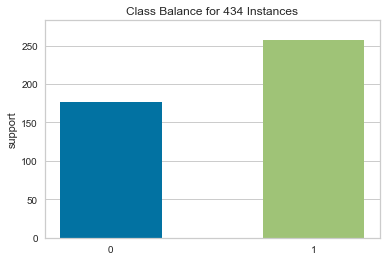

In [15]:
# Visualize distribution of y
from yellowbrick.target import ClassBalance

viz = ClassBalance()
viz.fit(y)
viz.show()

In [16]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [17]:
print (f"Train data: {Counter(y_train)}"), print (f"Test Data: {Counter(y_test)}")

Train data: Counter({1: 186, 0: 139})
Test Data: Counter({1: 71, 0: 38})


(None, None)

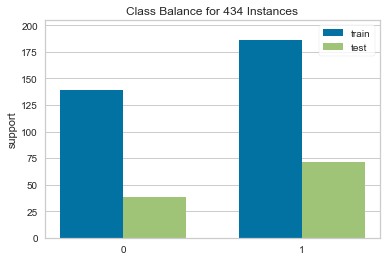

In [18]:
# Visualize train and test y
viz = ClassBalance()

viz.fit(y_train,y_test)
viz.show()

## Balanced Random Forest

In [19]:
# Train the Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
model_BRF = BalancedRandomForestClassifier(random_state=1,n_estimators=100)
model_BRF.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=1,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [20]:
# Calculated the balanced accuracy score
y_pred = model_BRF.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

1.0

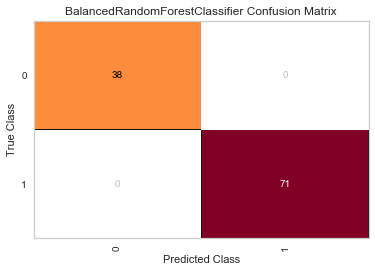

In [21]:
# Visualize confusion matrix
cm = ConfusionMatrix(model_BRF)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

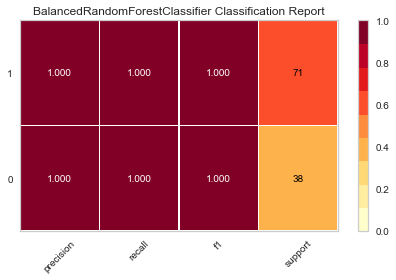

In [22]:
# Visualize imbalanced classification report
viz = ClassificationReport(model_BRF,support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [23]:
# List the features sorted in descending order by feature importance
importances = pd.Series(model_BRF.feature_importances_,X.columns).sort_values(ascending=False)
print (importances.to_string())

3-day Rolling         0.586820
5-day Rolling         0.226467
12-day Rolling        0.116128
Pos                   0.016041
Neu                   0.013699
3-day Rolling Std     0.012926
12-day Rolling Std    0.012345
5-day Rolling Std     0.008104
Neg                   0.004961
month                 0.002511


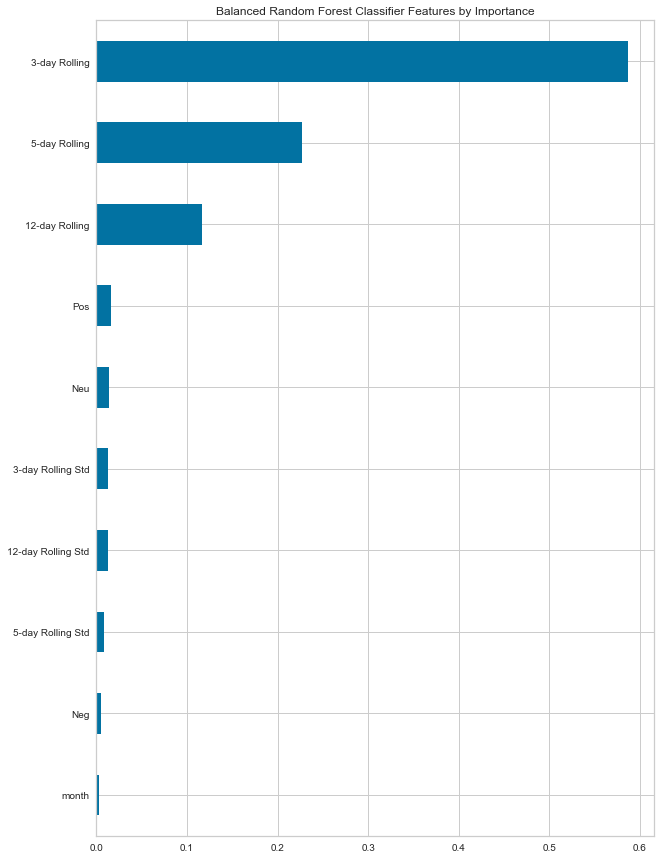

In [24]:
# Visualize feature importances
importances.sort_values(ascending=True).plot(kind='barh',figsize=(10,15),
                                             title="Balanced Random Forest Classifier Features by Importance")

## Easy Ensemble AdaBoost Classifier

In [25]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier

model_EEC = EasyEnsembleClassifier(n_estimators=100,random_state=1)
model_EEC.fit(X_train, y_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
                       random_state=1, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [26]:
# Calculated the balanced accuracy score
y_pred = model_EEC.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

1.0

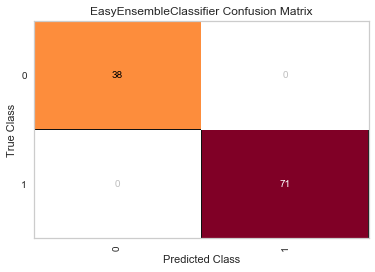

In [27]:
# Visualize the confusion matrix
cm = ConfusionMatrix(model_EEC)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

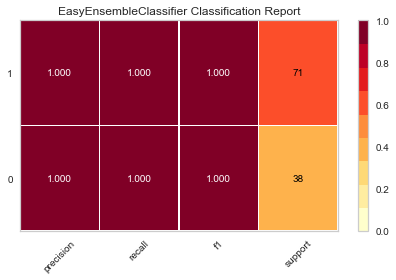

In [28]:
# Visualize the imbalanced classification report
viz = ClassificationReport(model_EEC,support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()